In [1]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import InMemorySaver

from langchain_core.tools import tool
from langchain_ollama import ChatOllama
from langchain_tavily import TavilySearch
from dotenv import load_dotenv
import os
load_dotenv()

True

In [2]:
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [4]:
system_prompt = """You are a helpful AI assistant.
- Use Tavily Search ONLY when the user asks about recent, factual, or web-based information.
- If the question is simple or general knowledge, answer directly without calling tools.
"""


llm = ChatOllama(model="llama3.1:8b", 
                 temperature=0,
                 system=system_prompt)


tavily_tool = TavilySearch(
    tavily_api_key=TAVILY_API_KEY,
    max_results=3
)

tools = [tavily_tool]

llm_with_tools = llm.bind_tools(tools)

In [5]:
llm_with_tools

RunnableBinding(bound=ChatOllama(model='llama3.1:8b', temperature=0.0), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list of domains to restrict search results to.\n\n        Use this parameter when:\n        1. The user explicitly requests information from specific websites (e.g., "Find climate data from nasa.gov")\n        2. The user ment

In [6]:
def chatbot_node(state: State):
    response = llm_with_tools.invoke(state["messages"])
    if hasattr(response, "tool_calls") and response.tool_calls:
        for tc in response.tool_calls:
            print(f"[TOOL CALL] Model requested tool: {tc['name']} with args: {tc['args']}")
    else:
        print("[NO TOOL CALL] Model responded directly.")

    return {"messages": [response]}

graph_builder.add_node("chatbot", chatbot_node)

In [7]:
# Tool execution node
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [8]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition) 
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

In [9]:
memory = InMemorySaver()
graph = graph_builder.compile(checkpointer=memory)

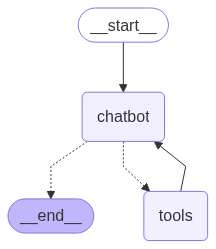

In [10]:
graph

In [11]:
def chat_loop():
    thread_id = "ollama_tavily_thread"
    config = {"configurable": {"thread_id": thread_id}}

    while True:
        user_input = input("\nUser: ")
        if user_input.lower() in ("quit", "exit", "q"):
            print("Goodbye!")
            break

        events = graph.stream(
            # {"messages": [{"role": "user", "content": user_input}]},
            {
                "messages": [
                            # {"role": "system", "content": "You are a helpful AI assistant. Use Tavily to look up real-time facts. Always provide short, reliable answers."},
                            {"role": "user", "content": user_input}
                        ]
                },
            config,
            stream_mode="values"
        )

        for event in events:
            if "messages" in event:
                print("Bot:", event["messages"][-1].content)
                
chat_loop()

Bot: who is the ceo of apple
[TOOL CALL] Model requested tool: tavily_search with args: {'include_domains': ['apple.com'], 'query': 'apple CEO'}
Bot: 
Bot: {"query": "apple CEO", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.apple.com/leadership/tim-cook/", "title": "Tim Cook - Apple Leadership", "content": "# Tim Cook Tim Cook is the CEO of Apple and serves on its board of directors. Before being named CEO in August 2011, Tim was Apple’s chief operating officer and was responsible for all of the company’s worldwide sales and operations, including end-to-end management of Apple’s supply chain, sales activities, and service and support in all markets and countries. Prior to joining Apple, Tim was vice president of Corporate Materials for Compaq and was responsible for procuring and managing all of Compaq’s product inventory. Previous to his work at Compaq, Tim was the chief operating officer of the Reseller Division at Intelligent Electronic